In [2]:
import tensorflow as tf

print("TF version:", tf.__version__)

# print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")
print(
    "GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE"
)


TF version: 2.12.0
GPU is NOT AVAILABLE


In [3]:
import matplotlib.pyplot as plt  # 用于绘制图形和可视化数据的 Python 库。
import numpy as np  # 用于数值计算和科学计算的 Python 库。
import os  # 提供了访问操作系统功能的模块，例如文件和目录操作。
import PIL  # Python Imaging Library，用于图像处理和操作的 Python 库。
from tensorflow.keras import layers  # TensorFlow 中的 Keras 模块，用于定义神经网络层
import time  # 提供了时间相关的函数和方法的 Python 模块
import glob  # 用于查找符合特定规则的文件路径名的 Python 模块。

from IPython import (
    display,
)  # 用于在 Jupyter Notebook 中显示图像和其他媒体的 Python 模块


In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5  # 将图片标准化到[-1,1] 区间内

In [6]:
buffer_size = 60000
batch_size = 256


In [7]:
# 批量化和打乱数据
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(buffer_size)
    .batch(batch_size)
)


In [8]:
def make_generator_model():
    model = tf.keras.Sequential()

    # 添加全连接层，输入维度为100，输出维度为7*7*256
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())  # 批归一化层
    model.add(layers.LeakyReLU())  # LeakyReLU激活函数

    # 重塑输出形状为(7, 7, 256)
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    # 添加转置卷积层，输出通道数为128，卷积核大小为(5, 5)，步长为(1, 1)，padding为"same"
    model.add(
        layers.Conv2DTranspose(
            128, (5, 5), strides=(1, 1), padding="same", use_bias=False
        )
    )
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())  # 批归一化层
    model.add(layers.LeakyReLU())  # LeakyReLU激活函数

    # 添加转置卷积层，输出通道数为64，卷积核大小为(5, 5)，步长为(2, 2)，padding为"same"
    model.add(
        layers.Conv2DTranspose(
            64, (5, 5), strides=(2, 2), padding="same", use_bias=False
        )
    )
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())  # 批归一化层
    model.add(layers.LeakyReLU())  # LeakyReLU激活函数

    # 添加转置卷积层，输出通道数为1，卷积核大小为(5, 5)，步长为(2, 2)，padding为"same"，激活函数为tanh
    model.add(
        layers.Conv2DTranspose(
            1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"
        )
    )
    assert model.output_shape == (None, 28, 28, 1)

    return model


In [9]:
generator = make_generator_model()
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

## 使用（未训练的）生成器创建一张图片

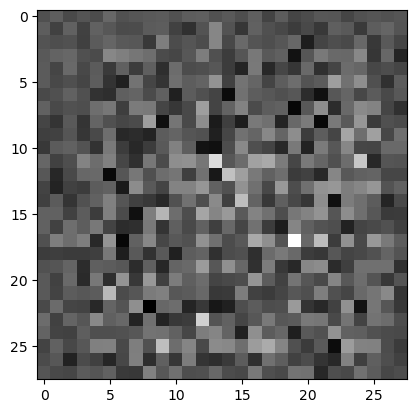

In [12]:
# 生成一个形状为 [1, 100] 的随机噪声向量
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# 表示在一个四维数组中，取第一个维度的第一个元素，然后取该元素的所有行和列，最后取该元素的第一个通道。
plt.imshow(generated_image[0, :, :, 0], cmap="gray")


## 构建判别器

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(
        layers.Conv2D(
            64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]
        )
    )
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(
        layers.Conv2D(
            128, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]
        )
    )
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


# 包含两个卷积层，每个卷积层后面跟着一个 LeakyReLU 激活函数和一个 Dropout 层，用于防止过拟合。
# 最后通过 Flatten 层将输出展平，然后接一个具有 1 个单元的全连接层，用于最终的分类。


In [14]:
discriminator = make_discriminator_model()
discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [15]:
# 判断结果
decision = discriminator(generated_image)
# 此时的结果应当应当趋近于0，表示为伪造图片
print(decision)


tf.Tensor([[-0.00516566]], shape=(1, 1), dtype=float32)


In [16]:
# 交叉熵损失函数
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [17]:
# 辨别模型损失函数
def discriminator_loss(real_output, fake_output):
    # 样本图希望结果趋近1
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 自己生成的图希望结果趋近0
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # 总损失
    total_loss = real_loss + fake_loss
    return total_loss


In [18]:
# 生成模型的损失函数
def generator_loss(fake_output):
    # 生成模型期望最终的结果越来越接近1，也就是真实样本
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


## 训练结果保存

In [20]:
checkpoint_dir = "./ckpt_dir/gan/"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator,
)


In [21]:
epochs = 100
noise_dim = 100
num_examples_to_generate = 16


In [ ]:
# 初始化16个种子向量，用于生成4x4的图片
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [ ]:
# @tf.function表示TensorFlow编译、缓存此函数，用于在训练中快速调用
@tf.function
def train_step(images):
    # 随机生成一个批次的种子向量
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 生成一个批次的图片
        generated_images = generator(noise, training=True)

        # 辨别一个批次的真实样本
        real_output = discriminator(images, training=True)
        # 辨别一个批次的生成图片
        fake_output = discriminator(generated_images, training=True)

        # 计算两个损失值
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # 根据损失值调整模型的权重参量
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    # 计算出的参量应用到模型
    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )


In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # 设置为非训练状态，生成一组图片
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    # 4格x4格拼接
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")

    # 保存为png
    plt.savefig("image_at_epoch_{:04d}.png".format(epoch))
    plt.show()


In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs + 1):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # 每个训练批次生成一张图片作为阶段成功
        print("=======================================")
        generate_and_save_images(generator, epoch + 1, seed)

        # 每20次迭代保存一次训练数据
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print("Time for epoch {} is {} sec".format(epoch + 1, time.time() - start))

    plt.close()


In [ ]:
# 遍历所有png图片，汇总为gif动图
def write_gif():
    anim_file = "dcgan.gif"
    with imageio.get_writer(anim_file, mode="I") as writer:
        filenames = glob.glob("image*.png")
        filenames = sorted(filenames)
        last = -1
        for i, filename in enumerate(filenames):
            frame = 2 * (i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)


# 生成一张初始状态的4格图片，应当是噪点
generate_and_save_images(generator, 0000, seed)

if TRAIN:
    # 以训练模式运行，进入训练状态
    train(train_dataset, epochs)
    write_gif()
else:
    # 非训练模式，恢复训练数据
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    print("After training:")
    # 显示训练完成后，生成图片的辨别结果
    generated_image = generator(noise, training=False)
    decision = discriminator(generated_image)
    # 结果应当趋近1
    print(decision)
    # 重新生成随机值，生成一组图片保存
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    generate_and_save_images(generator, 9999, seed)
